## Python Imports

In [10]:
import numpy as np
from math import sqrt
import torch
import pandas as pd
import torch.nn.functional as F
import random
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds
matplotlib.rc('font', **{'family': 'DejaVu Sans', 'size'   : 16})
matplotlib.rc('figure', figsize=(15, 7.5))

## Initial Setup and Rating Matrix Data

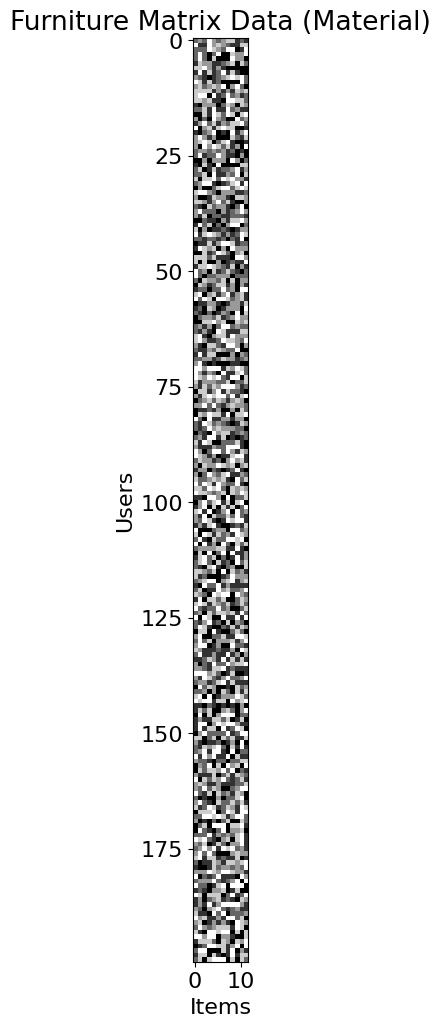

In [11]:
# Visualize the data
# 200 user data-points
# 12 initial furniture features
ratingMatrix = np.array(np.random.randint(6, size=(200, 12)), dtype=np.float32)
plt.figure(figsize=(200, 12))
plt.imshow(ratingMatrix, cmap='binary')
plt.xlabel('Items')
plt.ylabel('Users')
plt.title('Furniture Matrix Data (Material)')
plt.show()

## SVD Initial Approach

In [12]:
num_users, num_items = ratingMatrix.shape
print(ratingMatrix)

[[3. 2. 3. ... 4. 3. 4.]
 [0. 4. 4. ... 4. 1. 1.]
 [3. 3. 3. ... 5. 4. 0.]
 ...
 [3. 0. 0. ... 5. 2. 4.]
 [4. 1. 1. ... 4. 1. 1.]
 [3. 1. 5. ... 5. 1. 3.]]


## Factor Rating Matrix into SVD

Important Realization:
When we factor the matrix into 3 distinct categories (U, Sigma, V Transpose), the U represents the user-embedding (or n x k user matrix) and the V represents the item-embedding matrix (or k x n item matrix). We can break the rating matrix into its factors n x k user matrix and k x n item matrix. Where k is the given latent factors of the rating matrix. This would be characteristics or features of the items you have in the rating matrix (color, width, material, shape, stlye, height, weight of couch). U would essentially represent the weight of how much each user prefers different features, V would simply represent whether the feature is represented in the given object (whether couch actually does have the weight, style prefrences, normally binary-scale (0,1))

In [13]:
# Num. latent features for user and item matrices
# create sparse matrix using SciKit-Learn
# 5 latent features - width, height, length, color, material

latent_features = 5
A = csc_matrix(ratingMatrix)

u, s, vt = svds(A, latent_features)

print ('A:\n', A.toarray())
print ('=')
print ('\nU:\n', u)
print ('\nΣ:\n', s)
print ('\nV.T:\n', vt)

A:
 [[3. 2. 3. ... 4. 3. 4.]
 [0. 4. 4. ... 4. 1. 1.]
 [3. 3. 3. ... 5. 4. 0.]
 ...
 [3. 0. 0. ... 5. 2. 4.]
 [4. 1. 1. ... 4. 1. 1.]
 [3. 1. 5. ... 5. 1. 3.]]
=

U:
 [[-8.83222818e-02 -1.93912592e-02 -9.60875824e-02 -1.49115687e-02
   6.42387941e-02]
 [-3.37253138e-02 -9.64068994e-02 -2.85140201e-02  8.56109262e-02
   5.98439462e-02]
 [ 5.37503837e-03 -4.53187190e-02 -2.00805530e-01  4.73490246e-02
   5.41239940e-02]
 [ 1.02690347e-01  1.27538061e-02  7.47730210e-03 -9.13625434e-02
   6.76340535e-02]
 [ 5.89268431e-02  1.08512290e-01  1.61230024e-02 -1.52836546e-01
   8.50377306e-02]
 [-2.38781404e-02 -1.06486296e-02 -7.62327984e-02 -9.09688398e-02
   7.41676763e-02]
 [-1.40229343e-02  3.31889018e-02  2.84897350e-02 -2.49075219e-02
   9.02699679e-02]
 [-1.49289951e-01 -7.60386698e-03 -7.21177086e-02 -1.14368521e-01
   8.08230862e-02]
 [-2.48581283e-02 -2.38207541e-02  6.49580061e-02 -4.58137728e-02
   6.47331104e-02]
 [-4.56905961e-02  2.13985890e-03  5.81959728e-03 -2.65731439e-02
  

### Dot Product Between User and Item Matrix (U and V.T) Give Correlation of Features

In [22]:
print('Approximation of Ratings Matrix')
u.dot(np.diag(s).dot(vt))

Approximation of Ratings Matrix


array([[ 2.9710515 ,  1.4045858 ,  3.9189255 , ...,  3.7518806 ,
         2.7957847 ,  2.4392824 ],
       [ 2.289781  ,  4.20871   ,  3.179266  , ...,  3.241748  ,
         2.0593252 ,  1.760224  ],
       [ 3.3652472 ,  2.6433415 ,  3.149353  , ...,  5.023739  ,
         3.2740633 , -0.49005887],
       ...,
       [ 3.5254447 , -0.22011966,  2.2201934 , ...,  3.61821   ,
         1.4513913 ,  4.15706   ],
       [ 3.620486  ,  1.2497056 ,  0.5382273 , ...,  3.8810585 ,
         2.0679724 ,  1.0322717 ],
       [ 3.3536444 ,  1.8646216 ,  3.331777  , ...,  5.236531  ,
         0.83231205,  2.8015156 ]], dtype=float32)

In [23]:
print('Rounded Approximation of Ratings Matrix')
np.round(u.dot(np.diag(s).dot(vt)))

Rounded Approximation of Ratings Matrix


array([[ 3.,  1.,  4., ...,  4.,  3.,  2.],
       [ 2.,  4.,  3., ...,  3.,  2.,  2.],
       [ 3.,  3.,  3., ...,  5.,  3., -0.],
       ...,
       [ 4., -0.,  2., ...,  4.,  1.,  4.],
       [ 4.,  1.,  1., ...,  4.,  2.,  1.],
       [ 3.,  2.,  3., ...,  5.,  1.,  3.]], dtype=float32)

## Train until convergence using GD

In [35]:
def train_until_convergence(u, s, vt, ratingMatrix, learning_rate=0.001, convergence_threshold=1e-6, max_iterations=100, gradient_clip=5.0):
    """
    Trains the SVD decomposition until convergence using gradient descent.
    """

    # Normalize the rating matrix to the range 0-1
    min_rating = np.min(ratingMatrix)
    max_rating = np.max(ratingMatrix)
    normalized_matrix = (ratingMatrix - min_rating) / (max_rating - min_rating)

    u_trained = u.copy()
    vt_trained = vt.copy()
    s_trained = np.diag(s)

    for iteration in range(max_iterations):
        # Compute the current reconstruction error
        reconstructed_matrix = u_trained.dot(s_trained).dot(vt_trained)
        error_matrix = normalized_matrix - reconstructed_matrix
        current_error = np.sum(error_matrix**2)

        print(f"Iteration {iteration + 1}: Error = {current_error}")

        if iteration > 0 and abs(previous_error - current_error) < convergence_threshold:
            print("Converged!")
            break

        previous_error = current_error

        # Update U and V.T using gradient descent
        for i in range(u_trained.shape[0]):
            for k in range(u_trained.shape[1]):
                gradient_u = -2 * np.sum(error_matrix[i, :] * s_trained[k, k] * vt_trained[k, :])
                gradient_u = np.clip(gradient_u, -gradient_clip, gradient_clip)  # Clip gradients
                u_trained[i, k] -= learning_rate * gradient_u

        for k in range(vt_trained.shape[0]):
            for j in range(vt_trained.shape[1]):
                gradient_vt = -2 * np.sum(error_matrix[:, j] * s_trained[k, k] * u_trained[:, k])
                gradient_vt = np.clip(gradient_vt, -gradient_clip, gradient_clip)  # Clip gradients
                vt_trained[k, j] -= learning_rate * gradient_vt

    # Scale the reconstructed matrix back to the original range (0-5)
    final_matrix = u_trained.dot(s_trained).dot(vt_trained)
    final_matrix = final_matrix * (max_rating - min_rating) + min_rating

    return u_trained, s_trained, vt_trained, final_matrix


# Example usage
np.random.seed(42)
ratingMatrix = np.random.rand(5, 5) * 5  # Generate a random rating matrix with values from 0-5
u, s, vt = np.linalg.svd(ratingMatrix)
u_trained, s_trained, vt_trained, final_matrix = train_until_convergence(u, s, vt, ratingMatrix)

# Print the final approximated matrix
print("Final approximated matrix:")
print(final_matrix)

Iteration 1: Error = 107.96869045307702
Iteration 2: Error = 102.41240618510831
Iteration 3: Error = 97.07271042152628
Iteration 4: Error = 91.9431516300405
Iteration 5: Error = 87.01758157927118
Iteration 6: Error = 82.29011137629719
Iteration 7: Error = 77.75526027238791
Iteration 8: Error = 73.40809759209604
Iteration 9: Error = 69.24323062927449
Iteration 10: Error = 65.25542626095346
Iteration 11: Error = 61.43959523575962
Iteration 12: Error = 57.79077918841143
Iteration 13: Error = 54.304139863236756
Iteration 14: Error = 50.975501456385864
Iteration 15: Error = 47.80123300706919
Iteration 16: Error = 44.77748490998173
Iteration 17: Error = 41.900073197820554
Iteration 18: Error = 39.16396804324468
Iteration 19: Error = 36.5643302573265
Iteration 20: Error = 34.09649194389701
Iteration 21: Error = 31.75594034716468
Iteration 22: Error = 29.538462117627446
Iteration 23: Error = 27.44001235611541
Iteration 24: Error = 25.456452274800725
Iteration 25: Error = 23.584018956517788
Ite

In [20]:
def rmse(prediction, ground_truth):
    """
    Calculates the Root Mean Squared Error (RMSE) between the prediction and ground truth.

    Args:
        prediction (numpy.ndarray): The predicted ratings.
        ground_truth (numpy.ndarray): The actual ratings.

    Returns:
        float: The RMSE value.
    """
    # Ignore NaN values in the ground truth
    mask = ~np.isnan(ground_truth)
    prediction = prediction[mask]
    ground_truth = ground_truth[mask]

    return sqrt(np.mean((prediction - ground_truth)**2))

In [18]:
predicted_ratings = u.dot(np.diag(s).dot(vt))
rmse_value = rmse(predicted_ratings, ratingMatrix)
print(f"RMSE: {rmse_value}")

RMSE: 1.1995291541159376


## Results and Evaluation

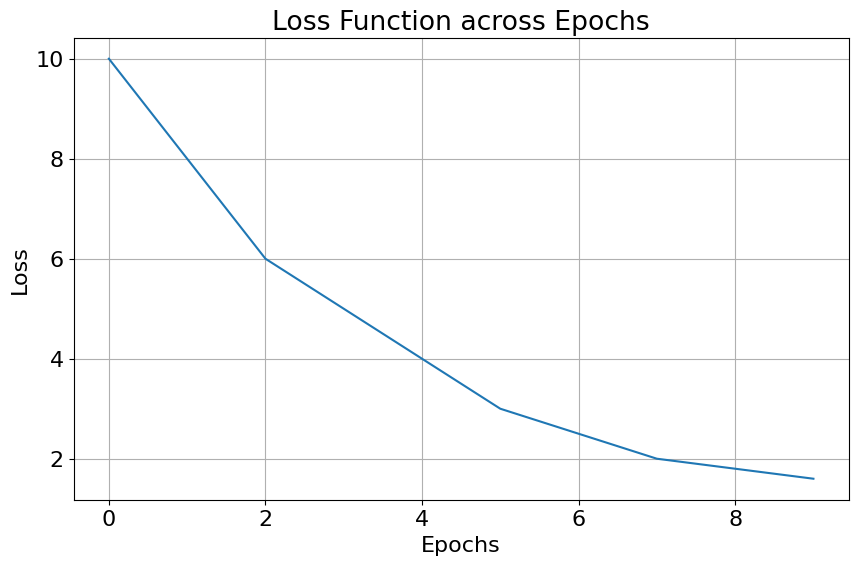

In [39]:
matplotlib.rc('font', **{'family': 'DejaVu Sans', 'size': 16})
matplotlib.rc('figure', figsize=(15, 7.5))


# Plotting the error
plt.figure(figsize=(10, 6))
plt.plot(errors)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function across Epochs')
plt.grid(True)
plt.show()